
# **Automatically classify consumer goods**

##***Supervised automatic classification of images***

*Place de marché* is a company that wants to launch an e-commerce marketplace.
Manual classification of items by sellers is unreliable and limited.

As a Data Scientist, I evaluated the feasibility of an automatic product classification system, using photos and descriptions. Here I will carry out supervised classification from the images and implement data augmentation in order to optimize the model.

*NB: The images and descriptions as well as all the data used here are public data available on the website of the company “Marketplace” and are not intellectual property.*

<u><strong>Summary</strong></u> :<br>
<br>
<strong>Tools</strong> <a href="https://colab.research.google.com/drive/1jwn4iiLWJBd8AxwMqkpZKefY7Y4V6gvd#scrollTo=ad04d6df">(here)</a><br><br>
<strong>III. Supervised automatic classification of images</strong><br>
     -- A. Data preprocessing and encoding <a href="https://colab.research.google.com/drive/1jwn4iiLWJBd8AxwMqkpZKefY7Y4V6gvd#scrollTo=f6165234">(here)</a><br>
     -- B. VGG16 <a href="https://colab.research.google.com/drive/1jwn4iiLWJBd8AxwMqkpZKefY7Y4V6gvd#scrollTo=fMwdhRNPSX0Z">(here)</a><br>
     -- C. ResNet <a href="https://colab.research.google.com/drive/1jwn4iiLWJBd8AxwMqkpZKefY7Y4V6gvd#scrollTo=mjAVZZE6Sevb">(here)</a><br>
     -- D. Inception <a href="https://colab.research.google.com/drive/1jwn4iiLWJBd8AxwMqkpZKefY7Y4V6gvd#scrollTo=iShfrwcSMrAu">(here)</a><br>
     -- E. Basic and advanced data augmentation on Inception model <a href="https://colab.research.google.com/drive/1jwn4iiLWJBd8AxwMqkpZKefY7Y4V6gvd#scrollTo=RMmMN5FEjIDS">(here)</a><br>

****

### **Tools**

In [204]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [205]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns
import warnings
import time
import tensorflow as tf

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras import layers, models
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Dropout
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing import image as keras_image
from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.resnet import ResNet50
from keras.applications.inception_v3 import InceptionV3

from sklearn import cluster, metrics, manifold, decomposition
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn import cluster, metrics

from sklearn.manifold import TSNE
from sklearn import cluster, metrics
from sklearn.metrics import silhouette_score

In [206]:
def split_column(df, column_name):
    """
    Split a DataFrame column into multiple columns using space as the separator.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the column to split.
    column_name (str): The name of the column to split.

    Returns:
    pandas.DataFrame: A DataFrame with the original column split into multiple columns.
    """
    if column_name in df.columns:
        new_cols = df[column_name].str.split(',', expand=True)
        # Rename the new columns
        new_cols.columns = [
            f"{column_name}_{i}" for i in range(new_cols.shape[1])
        ]
        # Concatenate the new columns to the original DataFrame
        df = pd.concat([df, new_cols], axis=1)
    else:
        print(f"Column '{column_name}' not found in DataFrame.")

    return df

In [207]:
def ARI_fct(features, N_CLUSTERS, encode_cat, perplexity=20):
    time1 = time.time()
    num_labels = len(l_cat)
    tsne = manifold.TSNE(n_components=2,
                         perplexity=perplexity,
                         n_iter=2000,
                         init='random',
                         learning_rate=200,
                         random_state=42)
    X_tsne = tsne.fit_transform(features)
    cls = cluster.KMeans(n_clusters=N_CLUSTERS, n_init=200, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(encode_cat, cls.labels_), 4)
    time2 = np.round(time.time() - time1, 0)
    print("ARI : ", ARI, "time : ", time2)

    return ARI, X_tsne, cls.labels_


def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI):
    fig = plt.figure(figsize=(15, 6))

    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0],
              labels=l_cat,
              loc="best",
              title="Categorie")
    plt.title('Representation of actual product categories')

    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0],
              labels=set(labels),
              loc="best",
              title="Clusters")
    plt.title('Representation of product categories by clusters')

    plt.show()
    print("ARI : ", ARI)


# Match kmeans clusters with true clusters
def clusters_matching(cat_true, cat_kmeans):
    conf_mat = confusion_matrix(cat_true, cat_kmeans)
    print(conf_mat)
    print()
    corresp = np.argmax(conf_mat, axis=0)
    print(corresp)
    labels = pd.Series(cat_true, name="cat_true").to_frame()
    labels['cat_kmeans'] = cat_kmeans
    labels['y_kmeans_transform'] = labels['cat_kmeans'].apply(
        lambda x: corresp[x])

    return labels['y_kmeans_transform']


def confusion_matrix_plot(y_true, y_pred, categories):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=categories)
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.setp(ax.get_xticklabels(),
             rotation=45,
             ha="right",
             rotation_mode="anchor")
    disp.plot(xticks_rotation=55, ax=ax, cmap=plt.cm.Blues)


def pca_(X):
    N_COMP = 70
    pca = PCA(n_components=N_COMP)
    X_pca = pca.fit_transform(X)
    return X_pca



---



## **I.Supervised automatic classification of images**

### **A. Data preprocessing and encoding**

In [208]:
data = pd.read_csv(
    "/content/drive/MyDrive/flipkart_com-ecommerce_sample_1050.csv", sep=",")
data.shape

(1050, 15)

In [209]:
# New df
data = data[["uniq_id", "product_category_tree", "image"]]
data.head()

,uniq_id,product_category_tree,image
0,55b85ea15a1536d46b7190ad6fff8ce7,"[""Home Furnishing >> Curtains & Accessories >>...",55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,7b72c92c2f6c40268628ec5f14c6d590,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",7b72c92c2f6c40268628ec5f14c6d590.jpg
2,64d5d4a258243731dc7bbb1eef49ad74,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",64d5d4a258243731dc7bbb1eef49ad74.jpg
3,d4684dcdc759dd9cdf41504698d737d8,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",d4684dcdc759dd9cdf41504698d737d8.jpg
4,6325b6870c54cd47be6ebfbffa620ec7,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",6325b6870c54cd47be6ebfbffa620ec7.jpg


In [210]:
# Removing special characters from the "product_category_tree" column
data['product_category_tree'] = data['product_category_tree'].str.replace(
    ">>", ",", regex=True)

# Call function to split column 'product_category_tree' of DataFrame 'data'
data = split_column(data, 'product_category_tree')
data['product_category_tree_0'] = data['product_category_tree_0'].astype(str)

# Remove special character
data['category'] = data['product_category_tree_0'].str.replace(
    "\['", "").str.replace("\W+", " ", regex=True).str.strip()

# Final df
data = data[["uniq_id", "category", "image"]]
data.head()

,uniq_id,category,image
0,55b85ea15a1536d46b7190ad6fff8ce7,Home Furnishing,55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,7b72c92c2f6c40268628ec5f14c6d590,Baby Care,7b72c92c2f6c40268628ec5f14c6d590.jpg
2,64d5d4a258243731dc7bbb1eef49ad74,Baby Care,64d5d4a258243731dc7bbb1eef49ad74.jpg
3,d4684dcdc759dd9cdf41504698d737d8,Home Furnishing,d4684dcdc759dd9cdf41504698d737d8.jpg
4,6325b6870c54cd47be6ebfbffa620ec7,Home Furnishing,6325b6870c54cd47be6ebfbffa620ec7.jpg


In [211]:
data.category.unique()

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor Festive Needs', 'Kitchen Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

In [212]:
image_directory = '/content/drive/MyDrive/pix/'
target_size = (224, 224)  # Target size for VGG16 and Resnet
target_size_inception = (299, 299)  # Target size for Inception

unique_ids = []
imgs_vgg_resnet = []
imgs_inception = []

for file_name in os.listdir(image_directory):
    img = Image.open(os.path.join(image_directory, file_name))

    # Process images for VGG16 and ResNet
    img_resized_vgg_resnet = img.resize(target_size)
    img_array_vgg_resnet = np.array(img_resized_vgg_resnet, dtype=np.uint8)
    img_eq_vgg_resnet = cv2.cvtColor(img_array_vgg_resnet, cv2.COLOR_RGB2YUV)
    img_eq_vgg_resnet[:, :, 0] = cv2.equalizeHist(img_eq_vgg_resnet[:, :, 0])
    img_eq_vgg_resnet = cv2.cvtColor(img_eq_vgg_resnet, cv2.COLOR_YUV2RGB)
    img_normalized_vgg_resnet = img_eq_vgg_resnet / 255.0

    # Process images for Inception
    img_resized_inception = img.resize(target_size_inception)
    img_array_inception = np.array(img_resized_inception, dtype=np.uint8)
    img_eq_inception = cv2.cvtColor(img_array_inception, cv2.COLOR_RGB2YUV)
    img_eq_inception[:, :, 0] = cv2.equalizeHist(img_eq_inception[:, :, 0])
    img_eq_inception = cv2.cvtColor(img_eq_inception, cv2.COLOR_YUV2RGB)
    img_normalized_inception = img_eq_inception / 255.0

    unique_ids.append(file_name.split('.')[0])
    imgs_vgg_resnet.append(img_normalized_vgg_resnet)
    imgs_inception.append(img_normalized_inception)

data_img_vgg_resnet = pd.DataFrame({'unique_id': unique_ids, 'img': imgs_vgg_resnet})
data_img_inception = pd.DataFrame({'unique_id': unique_ids, 'img': imgs_inception})

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [213]:
data_img_vgg_resnet.head(2)

,unique_id,img
0,0e73201f6d8807776e1d21c969078289,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,..."
1,3c4604dba348a99a2dfbbc2cd3928101,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,..."


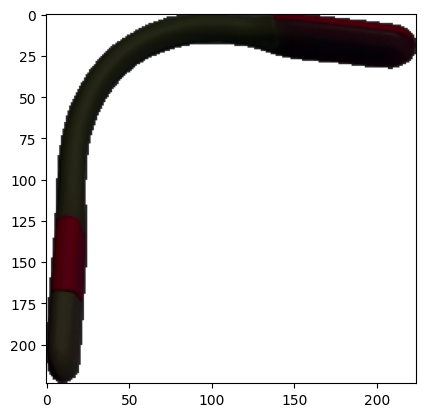

In [214]:
to_show = np.random.choice(list(data_img_vgg_resnet.unique_id))
plt.imshow(data_img_vgg_resnet[data_img_vgg_resnet.unique_id == to_show]['img'].item())

In [215]:
# Encoding categories
encode_fast = {
    'Home Furnishing': 0,
    'Baby Care': 1,
    'Watches': 2,
    'Home Decor Festive Needs': 3,
    'Kitchen Dining': 4,
    'Beauty and Personal Care': 5,
    'Computers': 6
}
data['encode_cat'] = data['category'].map(encode_fast)

# Function to retrieve encoded category by unique_id
def get_encoded_category(unique_id):
    return data[data['uniq_id'] == unique_id]['encode_cat'].item()

# Assuming 'data_img_vgg_resnet' and 'data_img_inception' are defined somewhere and have a 'unique_id' column
data_img_vgg_resnet['category_encoded'] = data_img_vgg_resnet['unique_id'].apply(get_encoded_category)
data_img_inception['category_encoded'] = data_img_inception['unique_id'].apply(get_encoded_category)

# Print DataFrame info to verify
data_img_inception.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1049 entries, 0 to 1048
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   unique_id         1049 non-null   object
 1   img               1049 non-null   object
 2   category_encoded  1049 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 24.7+ KB


In [216]:
y_cat_num = data_img_vgg_resnet['category_encoded']
l_cat = list(data['category'].unique())
N_CLUSTERS = len(l_cat)
y = y_cat_num.values
NB_CLASSES = y.max() + 1
y_one_hot = to_categorical(y, num_classes=NB_CLASSES)

In [217]:
data_img_vgg_resnet.head(2)

,unique_id,img,category_encoded
0,0e73201f6d8807776e1d21c969078289,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",4
1,3c4604dba348a99a2dfbbc2cd3928101,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",5


In [218]:
data_img_inception.head(2)

,unique_id,img,category_encoded
0,0e73201f6d8807776e1d21c969078289,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",4
1,3c4604dba348a99a2dfbbc2cd3928101,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",5


0


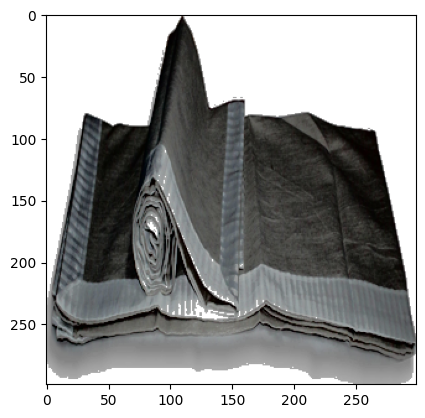

5


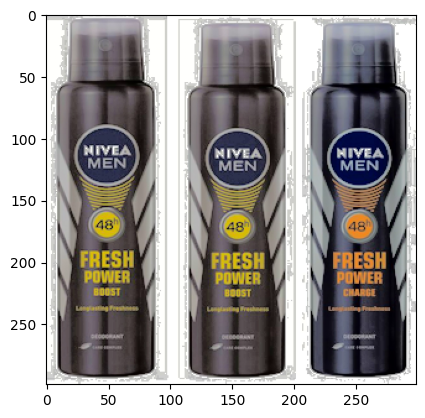

6


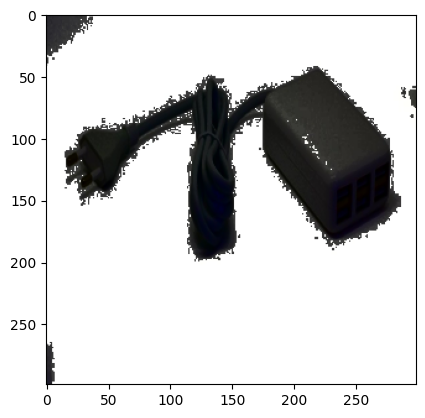

4


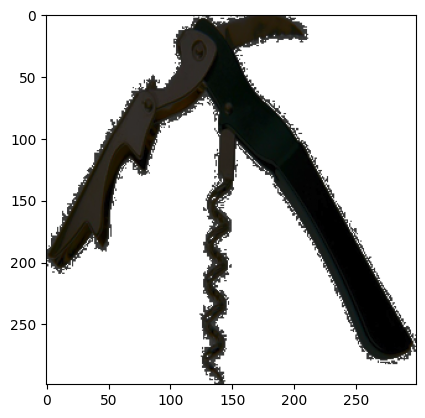

2


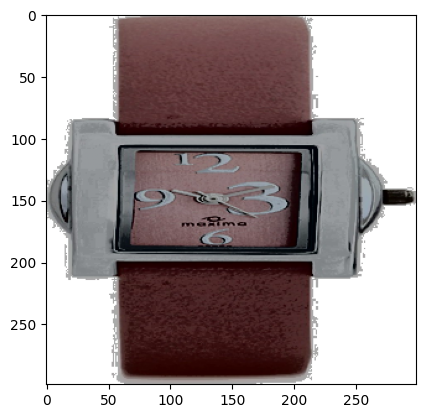

3


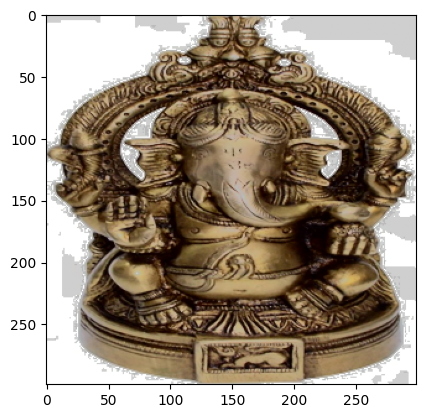

1


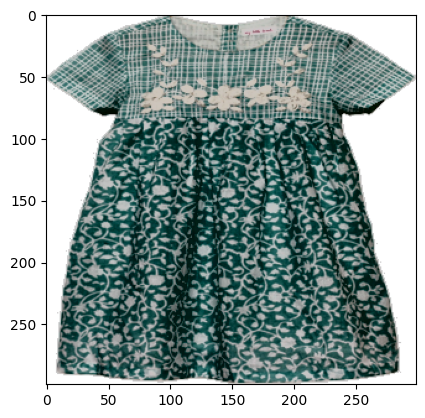

In [219]:
cat = list(data_img_inception['category_encoded'].unique())
showed = []

while len(cat) > 0:
    unique_id = np.random.choice(list(data_img_inception['unique_id']))
    row = data_img_inception[data_img_inception.unique_id == unique_id]
    if row['category_encoded'].item() not in showed:
        showed.append(row['category_encoded'].item())
        cat.remove(row['category_encoded'].item())
        print(row['category_encoded'].item())
        plt.imshow(row['img'].item())
        plt.show()

### **B. VGG16**

VGG16, pre-trained on the ImageNet database, is useful for various computer vision tasks such as image classification. With about 138 million parameters, it is a relatively heavy model requiring considerable computational and memory resources. However, its simple structure makes it a solid base for transfer learning, suitable for fine-tuning on specific datasets.

In [220]:
# Loading the VGG16 model without the top layers
model_vgg16_base = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# # Freezing base model layer weights
for layer in model_vgg16_base.layers:
    layer.trainable = False

# Added new layers for custom classification
model_vgg16 = Sequential([
    model_vgg16_base,
    Flatten(),
    Dense(512, activation='relu'),  # Increase in the number of neurons
    Dropout(0.3),  # Dropout rate adjustment
    Dense(NB_CLASSES, activation='softmax')
])

# Compilation du modèle
model_vgg16.compile(optimizer=Adam(learning_rate=2e-4),  # Learning rate adjustment
                              loss='categorical_crossentropy',
                              metrics=['accuracy'])
model_vgg16.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_11 (Flatten)        (None, 25088)             0         
                                                                 
 dense_22 (Dense)            (None, 512)               12845568  
                                                                 
 dropout_11 (Dropout)        (None, 512)               0         
                                                                 
 dense_23 (Dense)            (None, 7)                 3591      
                                                                 
Total params: 27563847 (105.15 MB)
Trainable params: 12849159 (49.02 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [221]:
# Conversion of stored images into a NumPy array, required here for machine learning processing
X = np.asarray([i for i in data_img_vgg_resnet['img']])
X.shape

(1049, 224, 224, 3)

In [222]:
# Step 1: Separate into training set (80% of the dataset) and temporary set (20% of the dataset)
X_train, X_temp, y_train, y_temp = train_test_split(X, y_one_hot, test_size=0.20, stratify=y_one_hot, random_state=42)

#Step 2: Separate the temporary set into validation and test sets (50% each of the temporary 20%, or 10% each of the total dataset)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

print(f"Shapes: {X_train.shape} and {X_test.shape}")

Shapes: (839, 224, 224, 3) and (105, 224, 224, 3)


In [223]:
# Define the callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               verbose=1,
                               restore_best_weights=True)

# Train the model with the callback
vgg16_history = model_vgg16.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=100,  # EarlyStopping will decide, even if the value is high here
    batch_size=32,
    callbacks=[early_stopping])

Epoch 1/100
27/27 [==============================] - 6s 178ms/step - loss: 1.2517 - accuracy: 0.5697 - val_loss: 0.8816 - val_accuracy: 0.7048
Epoch 2/100
27/27 [==============================] - 4s 160ms/step - loss: 0.4115 - accuracy: 0.8665 - val_loss: 0.7864 - val_accuracy: 0.7429
Epoch 3/100
27/27 [==============================] - 4s 163ms/step - loss: 0.1760 - accuracy: 0.9511 - val_loss: 0.7554 - val_accuracy: 0.7333
Epoch 4/100
27/27 [==============================] - 4s 159ms/step - loss: 0.0912 - accuracy: 0.9905 - val_loss: 0.7866 - val_accuracy: 0.7238
Epoch 5/100
27/27 [==============================] - 4s 157ms/step - loss: 0.0516 - accuracy: 0.9928 - val_loss: 0.7733 - val_accuracy: 0.7429
Epoch 6/100
27/27 [==============================] - 4s 156ms/step - loss: 0.0296 - accuracy: 0.9988 - val_loss: 0.7909 - val_accuracy: 0.7143
Epoch 7/100
27/27 [==============================] - 4s 153ms/step - loss: 0.0214 - accuracy: 1.0000 - val_loss: 0.8495 - val_accuracy: 0.7619

In [224]:
# Evaluation
test_loss, test_accuracy = model_vgg16.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

4/4 [==============================] - 0s 104ms/step - loss: 0.7061 - accuracy: 0.7714
Test Loss: 0.7061218023300171
Test Accuracy: 0.7714285850524902


In [225]:
# Prediction on validation data
predictions = model_vgg16.predict(X_test)
predictions_labels = predictions.argmax(axis=-1)

4/4 [==============================] - 1s 122ms/step


In [226]:
predictions = [
    prediction.flatten() for prediction in predictions
]
predictions = np.array(predictions)
print("Number of descriptors : ", predictions.shape)

Number of descriptors :  (105, 7)


In [227]:
ARI_vgg, X_tsne_vgg, labels_vgg = ARI_fct(
    predictions,
    N_CLUSTERS,
    predictions_labels,
    perplexity=35
)  # Tests with different perplexity values showed that 35 provides a good balance between preserving local and global data structures for this specific set

ARI :  0.8149 time :  1.0


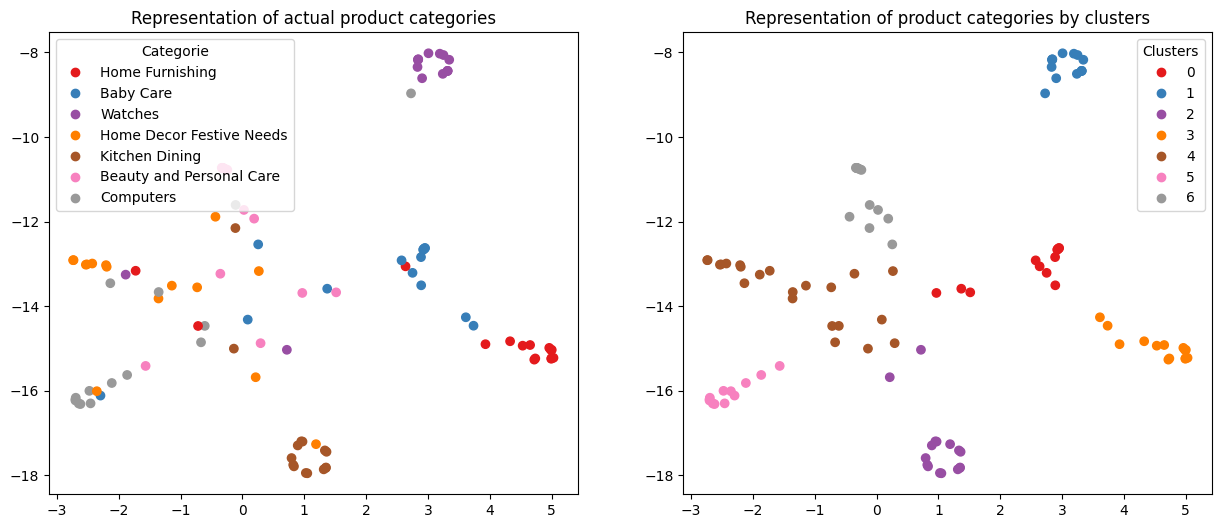

ARI :  0.8149


In [228]:
true_labels = np.argmax(y_test, axis=1)
TSNE_visu_fct(X_tsne_vgg, true_labels, labels_vgg, ARI_vgg)

In [229]:
# Convert predictions to class indices
vgg16_predicted_classes = np.argmax(predictions, axis=1)
print(classification_report(true_labels, vgg16_predicted_classes))

              precision    recall  f1-score   support

           0       0.86      0.80      0.83        15
           1       0.77      0.67      0.71        15
           2       0.87      0.87      0.87        15
           3       0.71      0.67      0.69        15
           4       0.78      0.93      0.85        15
           5       0.73      0.73      0.73        15
           6       0.69      0.73      0.71        15

    accuracy                           0.77       105
   macro avg       0.77      0.77      0.77       105
weighted avg       0.77      0.77      0.77       105



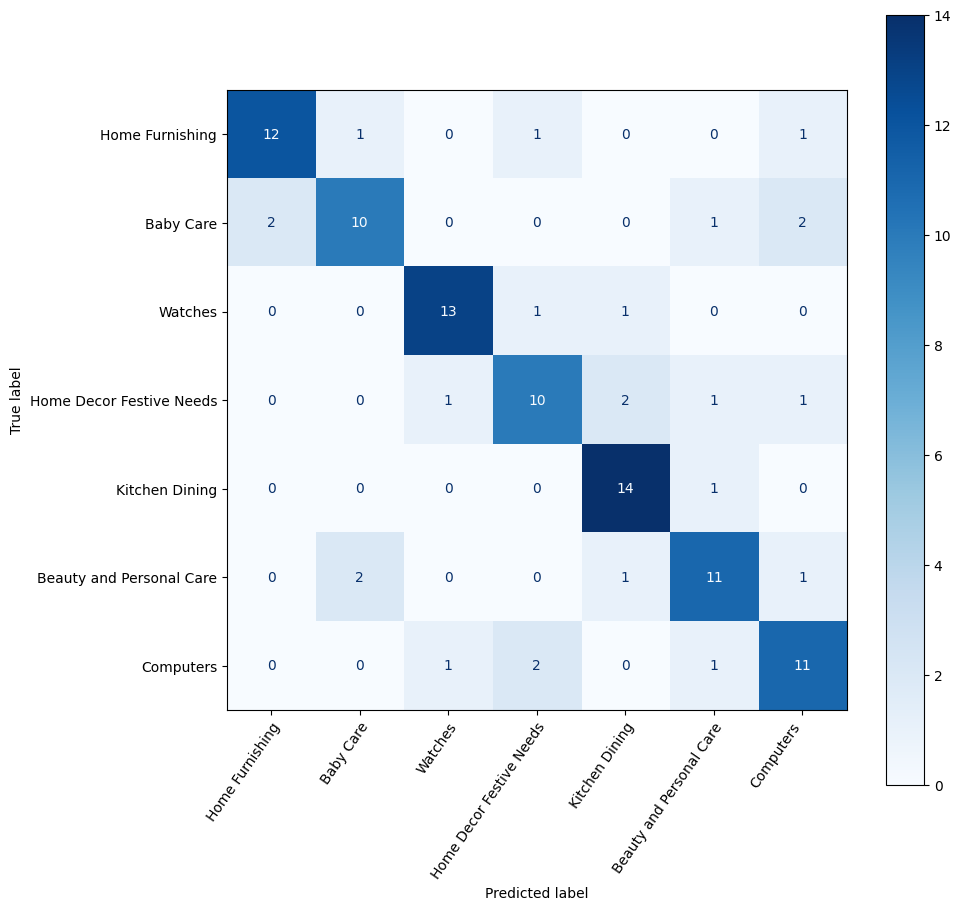

In [230]:
confusion_matrix_plot(true_labels, vgg16_predicted_classes, l_cat)

- **Model performance**: The adapted VGG16 model achieved a test accuracy of approximately 77% with a test loss of 0.761, demonstrating a good generalization ability.
- **Training efficiency**: Training incorporated early stopping after 13 epochs, which prevented overfitting and indicated that the model had reached an optimal point in learning.
- **F1 Scores**: The model showed variable F1 scores across different categories, performing particularly well in the Watches category, while suggesting room for improvement in Beauty and Personal Care.
- **Clustering quality**: The Adjusted Rand Index (ARI) score of 0.8149 signifies an excellent clustering outcome, with the model's predictions aligning strongly with the true product category labels.
- **Overall evaluation**: These metrics, together with the model's time efficiency, affirm that VGG16 is a robust choice for the classification task at hand, while also providing avenues for further optimization and refinement.

### **C. ResNet**

ResNet, also pre-trained on ImageNet, is noted for its improved performance through the introduction of residual connections that allow for deeper networks without performance loss. These enhancements make ResNet less resource-intensive compared to VGG16, while being extremely effective for fine-tuning in specific tasks like product classification.

In [231]:
# Loading the ResNet model without the top layers
model_resnet_base = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# # Freezing base model layer weights
for layer in model_resnet_base.layers:
    layer.trainable = False

# Added new layers for custom classification
model_resnet = Sequential([
    model_resnet_base,
    Flatten(),
    Dense(512, activation='relu'),  # Increase in the number of neurons
    Dropout(0.3),  # Dropout rate adjustment
    Dense(NB_CLASSES, activation='softmax')
])

# Compilation du modèle
model_resnet.compile(optimizer=Adam(learning_rate=2e-4),  # Learning rate adjustment
                              loss='categorical_crossentropy',
                              metrics=['accuracy'])
model_resnet.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_12 (Flatten)        (None, 100352)            0         
                                                                 
 dense_24 (Dense)            (None, 512)               51380736  
                                                                 
 dropout_12 (Dropout)        (None, 512)               0         
                                                                 
 dense_25 (Dense)            (None, 7)                 3591      
                                                                 
Total params: 74972039 (286.00 MB)
Trainable params: 51384327 (196.02 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [232]:
# Train the model with the callback
resnet_history = model_resnet.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=100,  # EarlyStopping will decide, even if the value is high here
    batch_size=32,
    callbacks=[early_stopping])

Epoch 1/100
27/27 [==============================] - 8s 184ms/step - loss: 3.8653 - accuracy: 0.1931 - val_loss: 1.9253 - val_accuracy: 0.2571
Epoch 2/100
27/27 [==============================] - 3s 128ms/step - loss: 1.7598 - accuracy: 0.3456 - val_loss: 1.6627 - val_accuracy: 0.4095
Epoch 3/100
27/27 [==============================] - 3s 129ms/step - loss: 1.5760 - accuracy: 0.4231 - val_loss: 1.5642 - val_accuracy: 0.4286
Epoch 4/100
27/27 [==============================] - 3s 117ms/step - loss: 1.4988 - accuracy: 0.4601 - val_loss: 1.6199 - val_accuracy: 0.3905
Epoch 5/100
27/27 [==============================] - 3s 118ms/step - loss: 1.4846 - accuracy: 0.4625 - val_loss: 1.5745 - val_accuracy: 0.4095
Epoch 6/100
27/27 [==============================] - 3s 118ms/step - loss: 1.3493 - accuracy: 0.5280 - val_loss: 1.6642 - val_accuracy: 0.3905
Epoch 7/100
27/27 [==============================] - 3s 119ms/step - loss: 1.3287 - accuracy: 0.5256 - val_loss: 1.5698 - val_accuracy: 0.4190

In [233]:
# Evaluation
test_loss_resnet, test_accuracy_resnet = model_resnet.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss_resnet}")
print(f"Test Accuracy: {test_accuracy_resnet}")

4/4 [==============================] - 0s 79ms/step - loss: 1.4967 - accuracy: 0.5143
Test Loss: 1.496666431427002
Test Accuracy: 0.5142857432365417


In [234]:
# Prediction on validation data
resnet_predictions = model_resnet.predict(X_test)
resnet_predictions_labels = resnet_predictions.argmax(axis=-1)

4/4 [==============================] - 1s 92ms/step


In [235]:
resnet_predictions = [
    resnet_prediction.flatten()
    for resnet_prediction in resnet_predictions
]
resnet_predictions = np.array(resnet_predictions)
print("Number of descriptors : ", resnet_predictions.shape)

Number of descriptors :  (105, 7)


In [236]:
ARI_resnet, X_tsne_resnet, labels_resnet = ARI_fct(
    resnet_predictions,
    N_CLUSTERS,
    resnet_predictions_labels,
    perplexity=35)

ARI :  0.6203 time :  1.0


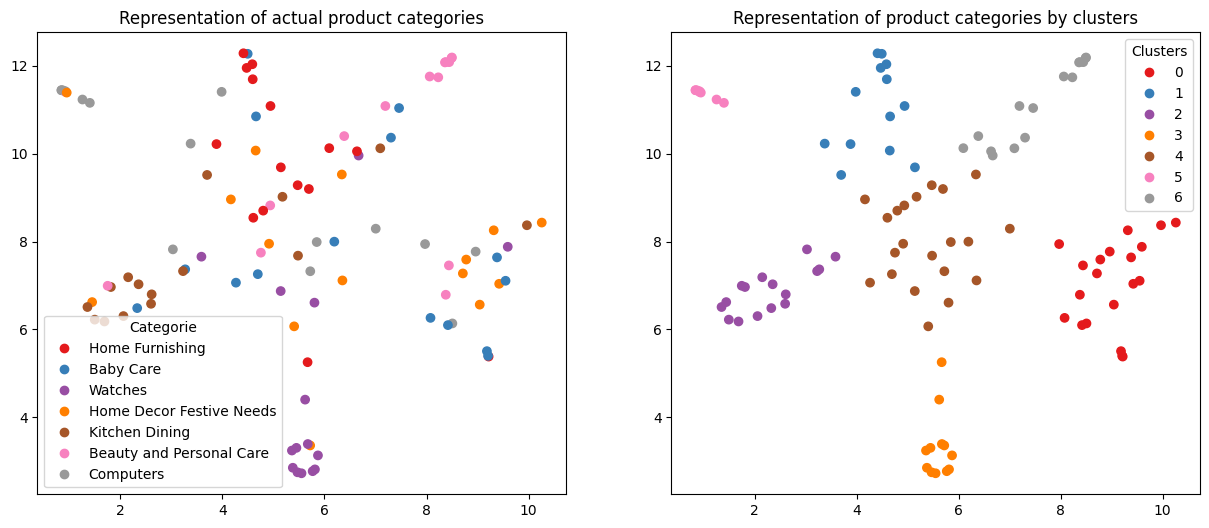

ARI :  0.6203


In [237]:
TSNE_visu_fct(X_tsne_resnet, true_labels, labels_resnet, ARI_resnet)

In [238]:
# Convert predictions to class indices
resnet_predicted_classes = np.argmax(resnet_predictions, axis=1)
print(classification_report(true_labels, resnet_predicted_classes))

              precision    recall  f1-score   support

           0       0.62      0.53      0.57        15
           1       0.36      0.27      0.31        15
           2       0.79      0.73      0.76        15
           3       0.36      0.27      0.31        15
           4       0.35      0.73      0.48        15
           5       0.60      0.60      0.60        15
           6       0.70      0.47      0.56        15

    accuracy                           0.51       105
   macro avg       0.54      0.51      0.51       105
weighted avg       0.54      0.51      0.51       105



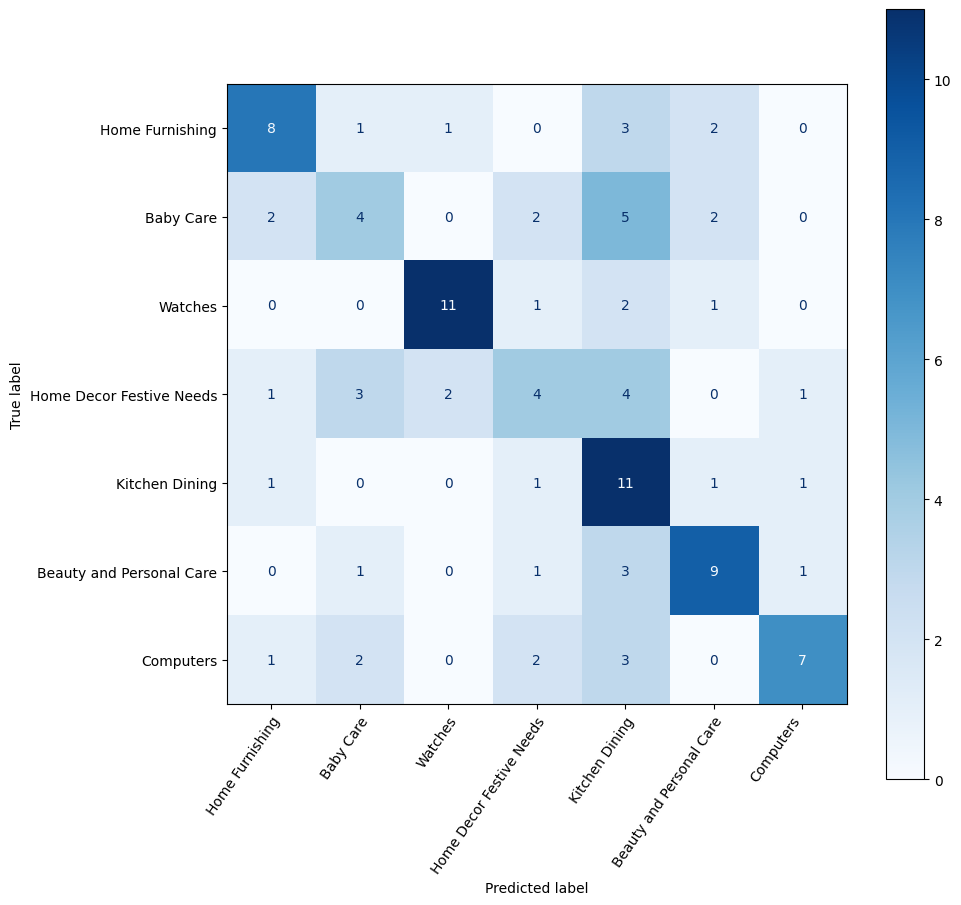

In [239]:
confusion_matrix_plot(true_labels, resnet_predicted_classes, l_cat)

- **Model performance**: The adapted ResNet model attained a test accuracy of approximately 51.4% with a test loss of 1.4696, indicating that there is potential for improvement in model generalization.
- **Training efficiency**: The training process incorporated early stopping after 29 epochs, which helped in preventing overfitting and indicated an early convergence, albeit with a lower validation accuracy peak compared to VGG16.
- **F1 Scores**: The F1 scores for ResNet also varied across different categories. The scores suggest that while certain categories like Watches were well-classified, others such as Baby Care and Beauty and Personal Care could benefit from further model tuning.
- **Clustering quality**: The Adjusted Rand Index (ARI) score with ResNet was 0.6203, which, although lower than VGG16's ARI score, still represents a decent level of clustering that aligns reasonably well with the true labels of the product categories.
- **Overall evaluation**: Considering these metrics and the clustering performance, ResNet shows promise but seems to require more refinement to reach the efficacy demonstrated by VGG16 in this specific task. The results provide a foundation for further optimization, which may include hyperparameter tuning, data augmentation, or exploration of different pre-processing techniques.

### **D. Inception**

The Inception model, or GoogLeNet, innovates with a structure composed of 'inception' modules that process information at various scales. This complex architecture makes it very effective at capturing subtle features in large image databases. Inception is ideal for tasks requiring high accuracy and can also be efficiently fine-tuned on more targeted datasets.

In [240]:
# Loading the inception model without the top layers
model_inception_base = InceptionV3(weights="imagenet", include_top=False, input_shape=(299, 299, 3))

# # Freezing base model layer weights
for layer in model_inception_base.layers:
    layer.trainable = False

# Added new layers for custom classification
model_inception = Sequential([
    model_inception_base,
    Flatten(),
    Dense(512, activation='relu'),  # Increase in the number of neurons
    Dropout(0.3),  # Dropout rate adjustment
    Dense(NB_CLASSES, activation='softmax')
])

# Compilation du modèle
model_inception.compile(optimizer=Adam(learning_rate=2e-4),  # Learning rate adjustment
                              loss='categorical_crossentropy',
                              metrics=['accuracy'])
model_inception.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten_13 (Flatten)        (None, 131072)            0         
                                                                 
 dense_26 (Dense)            (None, 512)               67109376  
                                                                 
 dropout_13 (Dropout)        (None, 512)               0         
                                                                 
 dense_27 (Dense)            (None, 7)                 3591      
                                                                 
Total params: 88915751 (339.19 MB)
Trainable params: 67112967 (256.02 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [241]:
# Conversion of stored images into a NumPy array, required here for machine learning processing
X_ = np.asarray([i for i in data_img_inception['img']])
X_.shape

(1049, 299, 299, 3)

In [242]:
# Step 1: Separate into training set (80% of the dataset) and temporary set (20% of the dataset)
X_train_, X_temp_, y_train_, y_temp_ = train_test_split(X_, y_one_hot, test_size=0.20, stratify=y_one_hot, random_state=42)

#Step 2: Separate the temporary set into validation and test sets (50% each of the temporary 20%, or 10% each of the total dataset)
X_val_, X_test_, y_val_, y_test_ = train_test_split(X_temp_, y_temp_, test_size=0.50, stratify=y_temp, random_state=42)

print(f"Shapes: {X_train_.shape} and {X_test_.shape}")

Shapes: (839, 299, 299, 3) and (105, 299, 299, 3)


In [243]:
# Train the model with the callback
inception_history = model_inception.fit(
    X_train_,
    y_train_,
    validation_data=(X_val_, y_val_),
    epochs=100,  # EarlyStopping will decide, even if the value is high here
    batch_size=32,
    callbacks=[early_stopping])

Epoch 1/100
27/27 [==============================] - 11s 245ms/step - loss: 5.9803 - accuracy: 0.5221 - val_loss: 0.7576 - val_accuracy: 0.7714
Epoch 2/100
27/27 [==============================] - 5s 168ms/step - loss: 0.4881 - accuracy: 0.8784 - val_loss: 0.6079 - val_accuracy: 0.8190
Epoch 3/100
27/27 [==============================] - 4s 153ms/step - loss: 0.1504 - accuracy: 0.9523 - val_loss: 0.6757 - val_accuracy: 0.8190
Epoch 4/100
27/27 [==============================] - 4s 155ms/step - loss: 0.0876 - accuracy: 0.9690 - val_loss: 0.7531 - val_accuracy: 0.8190
Epoch 5/100
27/27 [==============================] - 5s 172ms/step - loss: 0.0342 - accuracy: 0.9940 - val_loss: 0.5812 - val_accuracy: 0.8667
Epoch 6/100
27/27 [==============================] - 4s 157ms/step - loss: 0.0255 - accuracy: 0.9905 - val_loss: 0.6283 - val_accuracy: 0.8190
Epoch 7/100
27/27 [==============================] - 4s 156ms/step - loss: 0.0367 - accuracy: 0.9917 - val_loss: 0.6364 - val_accuracy: 0.819

In [244]:
# Evaluation
test_loss_inception, test_accuracy_inception = model_inception.evaluate(X_test_, y_test_, verbose=1)
print(f"Test Loss: {test_loss_inception}")
print(f"Test Accuracy: {test_accuracy_inception}")

4/4 [==============================] - 0s 99ms/step - loss: 0.6922 - accuracy: 0.8286
Test Loss: 0.6922065615653992
Test Accuracy: 0.8285714387893677


In [245]:
# Prediction on validation data
inception_predictions = model_inception.predict(X_test_)
inception_predictions_labels = inception_predictions.argmax(axis=-1)

4/4 [==============================] - 2s 118ms/step


In [246]:
inception_predictions = [
    inception_prediction.flatten()
    for inception_prediction in inception_predictions
]
inception_predictions = np.array(inception_predictions)
print("Number of descriptors : ", inception_predictions.shape)

Number of descriptors :  (105, 7)


In [247]:
ARI_inception, X_tsne_inception, labels_inception = ARI_fct(
    inception_predictions,
    N_CLUSTERS,
    inception_predictions_labels,
    perplexity=35)

ARI :  0.976 time :  1.0


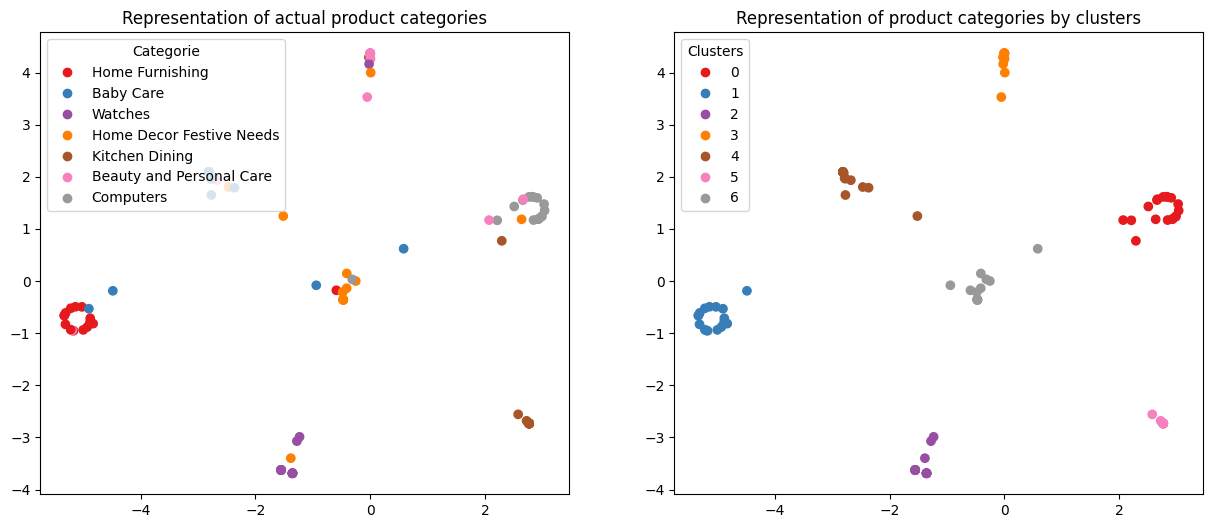

ARI :  0.976


In [248]:
TSNE_visu_fct(X_tsne_inception, true_labels, labels_inception, ARI_inception)

In [249]:
# Convert predictions to class indices
inception_predicted_classes = np.argmax(inception_predictions, axis=1)

print(classification_report(true_labels, inception_predicted_classes))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87        15
           1       0.79      0.73      0.76        15
           2       0.93      0.93      0.93        15
           3       0.77      0.67      0.71        15
           4       1.00      0.87      0.93        15
           5       0.79      0.73      0.76        15
           6       0.74      0.93      0.82        15

    accuracy                           0.83       105
   macro avg       0.83      0.83      0.83       105
weighted avg       0.83      0.83      0.83       105



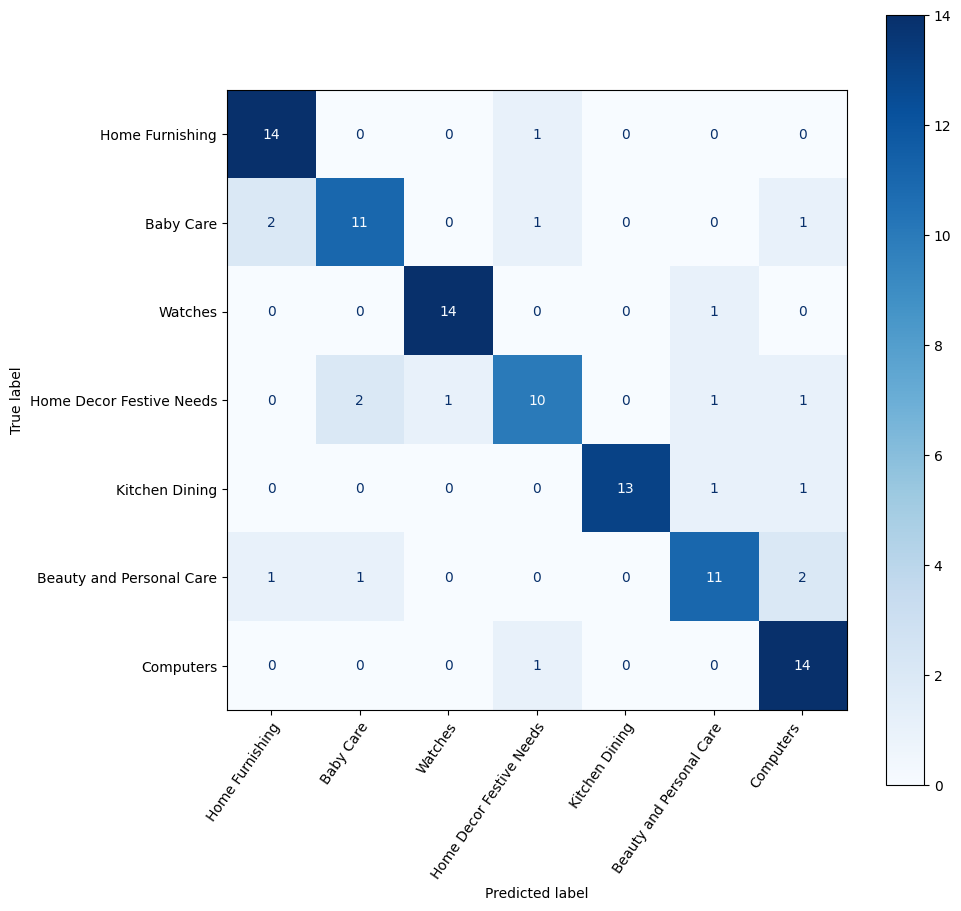

In [250]:
confusion_matrix_plot(true_labels, inception_predicted_classes, l_cat)

- **Model performance**: The adapted Inception model achieved a test accuracy of approximately 82.6% with a test loss of 0.6922, showcasing strong generalization capabilities.
- **Training efficiency**: The training process included early stopping after 15 epochs, suggesting the model quickly reached a satisfactory level of performance without overfitting.
- **F1 Scores**: The F1 scores for Inception were consistent across various categories, with particularly high scores for categories like Watches and Computers, demonstrating the model's capability to classify with high precision and recall.
- **Clustering quality**: The Adjusted Rand Index (ARI) score with Inception was 0.976, indicating an excellent clustering alignment with the true labels of the product categories, outperforming both VGG16 and ResNet in this aspect.
- **Overall evaluation**: Given these metrics, the Inception model has shown to be highly effective for this classification task, surpassing the performance of both the VGG16 and ResNet models. The high ARI score and balanced F1 scores across categories suggest that Inception is quite adept at capturing the nuanced features necessary for product classification. The results underscore Inception's potential as a robust choice for this application, with possibilities for further fine-tuning to achieve even better performance.

### **E. Basic and advanced data augmentation on Inception model**

Data augmentation consists of generating new training data from existing data, by various transformations (rotate, zoom, shift, flip...) randomly to reduce overfitting and improve the generalization of the model.

With already the best overall performance among the three models, the increase in data on the Inception model could either solidify its robustness or, conversely, not provide as marked an improvement as for the other less efficient models. We will nevertheless know if Inception's generalization capabilities are already maximized or if they can be further improved.

In [251]:
# Added new layers for custom classification
model_inception_basic = Sequential([
    model_inception_base,
    Flatten(),
    Dense(512, activation='relu'),  # Increase in the number of neurons
    Dropout(0.3),  # Dropout rate adjustment
    Dense(NB_CLASSES, activation='softmax')
])

# Compilation du modèle
model_inception_basic.compile(optimizer=Adam(learning_rate=2e-4),  # Learning rate adjustment
                              loss='categorical_crossentropy',
                              metrics=['accuracy'])
model_inception_basic.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten_14 (Flatten)        (None, 131072)            0         
                                                                 
 dense_28 (Dense)            (None, 512)               67109376  
                                                                 
 dropout_14 (Dropout)        (None, 512)               0         
                                                                 
 dense_29 (Dense)            (None, 7)                 3591      
                                                                 
Total params: 88915751 (339.19 MB)
Trainable params: 67112967 (256.02 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [252]:
# Define an image data generator with basic augmentations
datagen_basic = ImageDataGenerator(horizontal_flip=True,
                                   rotation_range=20,
                                   zoom_range=0.2,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   fill_mode='nearest')

# Fit the generator to your data
datagen_basic.fit(X_train_)

In [253]:
# Training the model with the basic augmentation
history_basic = model_inception_basic.fit_generator(
    datagen_basic.flow(X_train_, y_train_, batch_size=32),
    validation_data=(X_val_, y_val_),
    steps_per_epoch=len(X_train_) // 32,
    epochs=100,
    callbacks=[early_stopping])

<ipython-input-253-61b30eb0c89d>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_basic = model_inception_basic.fit_generator(


Epoch 1/100
26/26 [==============================] - 21s 641ms/step - loss: 6.8288 - accuracy: 0.4833 - val_loss: 0.8465 - val_accuracy: 0.7810
Epoch 2/100
26/26 [==============================] - 15s 577ms/step - loss: 0.9981 - accuracy: 0.7336 - val_loss: 0.7174 - val_accuracy: 0.7714
Epoch 3/100
26/26 [==============================] - 15s 566ms/step - loss: 0.5533 - accuracy: 0.8129 - val_loss: 0.4929 - val_accuracy: 0.8476
Epoch 4/100
26/26 [==============================] - 15s 564ms/step - loss: 0.4027 - accuracy: 0.8798 - val_loss: 0.4997 - val_accuracy: 0.8571
Epoch 5/100
26/26 [==============================] - 15s 559ms/step - loss: 0.3569 - accuracy: 0.8885 - val_loss: 0.5820 - val_accuracy: 0.8476
Epoch 6/100
26/26 [==============================] - 15s 561ms/step - loss: 0.3287 - accuracy: 0.8922 - val_loss: 0.5741 - val_accuracy: 0.8857
Epoch 7/100
26/26 [==============================] - 15s 582ms/step - loss: 0.2962 - accuracy: 0.9021 - val_loss: 0.4759 - val_accuracy:

In [254]:
# Evaluation
test_loss_inception_basic, test_accuracy_inception_basic = model_inception_basic.evaluate(X_test_, y_test_, verbose=1)
print(f"Test Loss: {test_loss_inception_basic}")
print(f"Test Accuracy: {test_accuracy_inception_basic}")

4/4 [==============================] - 0s 99ms/step - loss: 0.6463 - accuracy: 0.7714
Test Loss: 0.6462507843971252
Test Accuracy: 0.7714285850524902


In [255]:
# Prediction on validation data
inception_predictions_basic = model_inception_basic.predict(X_test_)
inception_predictions_basic_labels = inception_predictions_basic.argmax(
    axis=-1)

4/4 [==============================] - 2s 117ms/step


In [256]:
inception_predictions_basic = [
    inception_prediction_basic.flatten()
    for inception_prediction_basic in inception_predictions_basic
]
inception_predictions_basic = np.array(inception_predictions_basic)
print("Number of descriptors : ", inception_predictions_basic.shape)

Number of descriptors :  (105, 7)


In [257]:
ARI_inception_basic, X_tsne_inception_basic, labels_inception_basic = ARI_fct(
    inception_predictions_basic,
    N_CLUSTERS,
    inception_predictions_basic_labels,
    perplexity=35)

ARI :  0.8891 time :  1.0


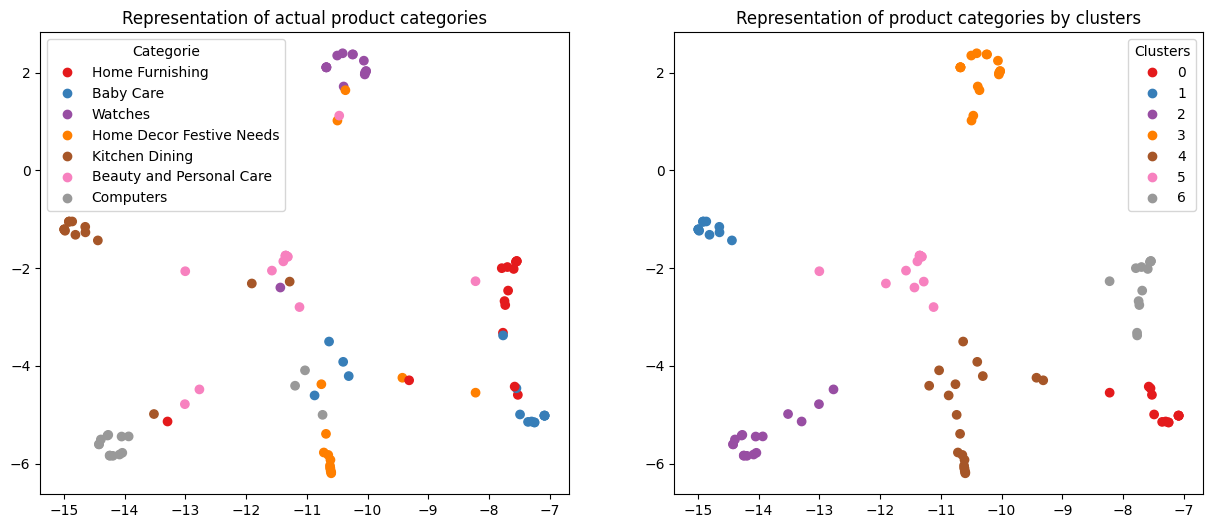

ARI :  0.8891


In [258]:
TSNE_visu_fct(X_tsne_inception_basic, true_labels, labels_inception_basic,
              ARI_inception_basic)

In [259]:
# Convert predictions to class indices
inception_basic_predicted_classes = np.argmax(inception_predictions_basic,
                                           axis=1)
print(classification_report(true_labels, inception_basic_predicted_classes))

              precision    recall  f1-score   support

           0       0.92      0.73      0.81        15
           1       0.69      0.73      0.71        15
           2       0.82      0.93      0.87        15
           3       0.65      0.73      0.69        15
           4       0.92      0.80      0.86        15
           5       0.71      0.67      0.69        15
           6       0.75      0.80      0.77        15

    accuracy                           0.77       105
   macro avg       0.78      0.77      0.77       105
weighted avg       0.78      0.77      0.77       105



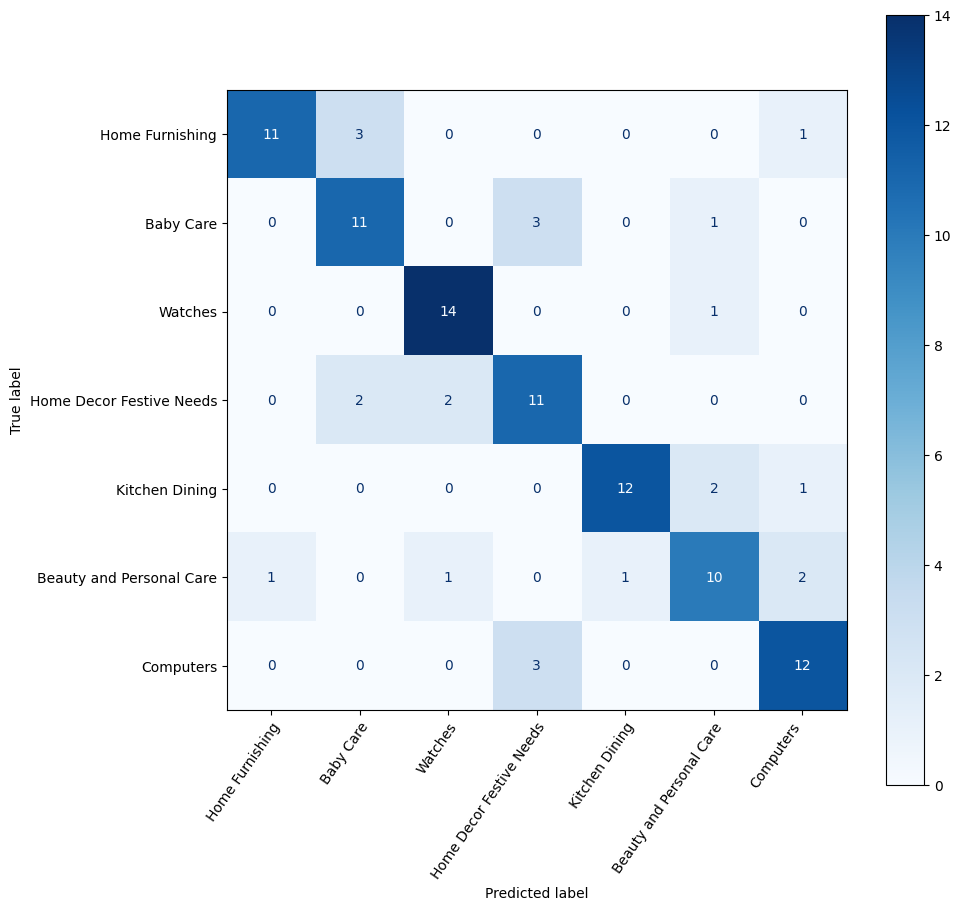

In [260]:
confusion_matrix_plot(true_labels, inception_basic_predicted_classes, l_cat)

In [261]:
# Added new layers for custom classification
model_inception_adv = Sequential([
    model_inception_base,
    Flatten(),
    Dense(512, activation='relu'),  # Increase in the number of neurons
    Dropout(0.3),  # Dropout rate adjustment
    Dense(NB_CLASSES, activation='softmax')
])

# Compilation du modèle
model_inception_adv.compile(optimizer=Adam(learning_rate=2e-4),  # Learning rate adjustment
                              loss='categorical_crossentropy',
                              metrics=['accuracy'])
model_inception_adv.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten_15 (Flatten)        (None, 131072)            0         
                                                                 
 dense_30 (Dense)            (None, 512)               67109376  
                                                                 
 dropout_15 (Dropout)        (None, 512)               0         
                                                                 
 dense_31 (Dense)            (None, 7)                 3591      
                                                                 
Total params: 88915751 (339.19 MB)
Trainable params: 67112967 (256.02 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [262]:
# Define an image data generator with advanced augmentations
datagen_advanced = ImageDataGenerator(horizontal_flip=True,
                                      vertical_flip=True,
                                      rotation_range=30,
                                      zoom_range=0.3,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.15,
                                      fill_mode='reflect')

# Fit the generator to your data
datagen_advanced.fit(X_train_)

In [263]:
# Training the model with the advanced augmentation
history_advanced = model_inception_adv.fit_generator(
    datagen_advanced.flow(X_train_, y_train_, batch_size=32),
    validation_data=(X_val_, y_val_),
    steps_per_epoch=len(X_train_) // 32,
    epochs=100,
    callbacks=[early_stopping])

<ipython-input-263-5d241986ffc8>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_advanced = model_inception_adv.fit_generator(


Epoch 1/100
26/26 [==============================] - 23s 720ms/step - loss: 7.4768 - accuracy: 0.3990 - val_loss: 1.5284 - val_accuracy: 0.6381
Epoch 2/100
26/26 [==============================] - 17s 649ms/step - loss: 1.4998 - accuracy: 0.6605 - val_loss: 0.7707 - val_accuracy: 0.7429
Epoch 3/100
26/26 [==============================] - 16s 613ms/step - loss: 0.8433 - accuracy: 0.7125 - val_loss: 0.5672 - val_accuracy: 0.8381
Epoch 4/100
26/26 [==============================] - 17s 629ms/step - loss: 0.8379 - accuracy: 0.7175 - val_loss: 0.6828 - val_accuracy: 0.8000
Epoch 5/100
26/26 [==============================] - 17s 645ms/step - loss: 0.7784 - accuracy: 0.7299 - val_loss: 0.5621 - val_accuracy: 0.8286
Epoch 6/100
26/26 [==============================] - 16s 599ms/step - loss: 0.6858 - accuracy: 0.7485 - val_loss: 0.6779 - val_accuracy: 0.8000
Epoch 7/100
26/26 [==============================] - 16s 630ms/step - loss: 0.6488 - accuracy: 0.7757 - val_loss: 0.5710 - val_accuracy:

In [264]:
# Evaluation
test_loss_inception_adv, test_accuracy_inception_adv = model_inception_adv.evaluate(X_test_, y_test_, verbose=1)
print(f"Test Loss: {test_loss_inception_adv}")
print(f"Test Accuracy: {test_accuracy_inception_adv}")

4/4 [==============================] - 0s 99ms/step - loss: 0.6130 - accuracy: 0.7905
Test Loss: 0.6129620671272278
Test Accuracy: 0.7904762029647827


In [265]:
# Prediction on validation data
inception_predictions_adv = model_inception_adv.predict(X_test_)
inception_predictions_adv_labels = inception_predictions_adv.argmax(
    axis=-1)

4/4 [==============================] - 2s 117ms/step


In [266]:
inception_predictions_adv = [
    inception_prediction_adv.flatten()
    for inception_prediction_adv in inception_predictions_adv
]
inception_predictions_adv = np.array(inception_predictions_adv)
print("Number of descriptors : ", inception_predictions_adv.shape)

Number of descriptors :  (105, 7)


In [267]:
ARI_inception_adv, X_tsne_inception_adv, labels_inception_adv = ARI_fct(
    inception_predictions_adv,
    N_CLUSTERS,
    inception_predictions_adv_labels,
    perplexity=35)

ARI :  0.8041 time :  1.0


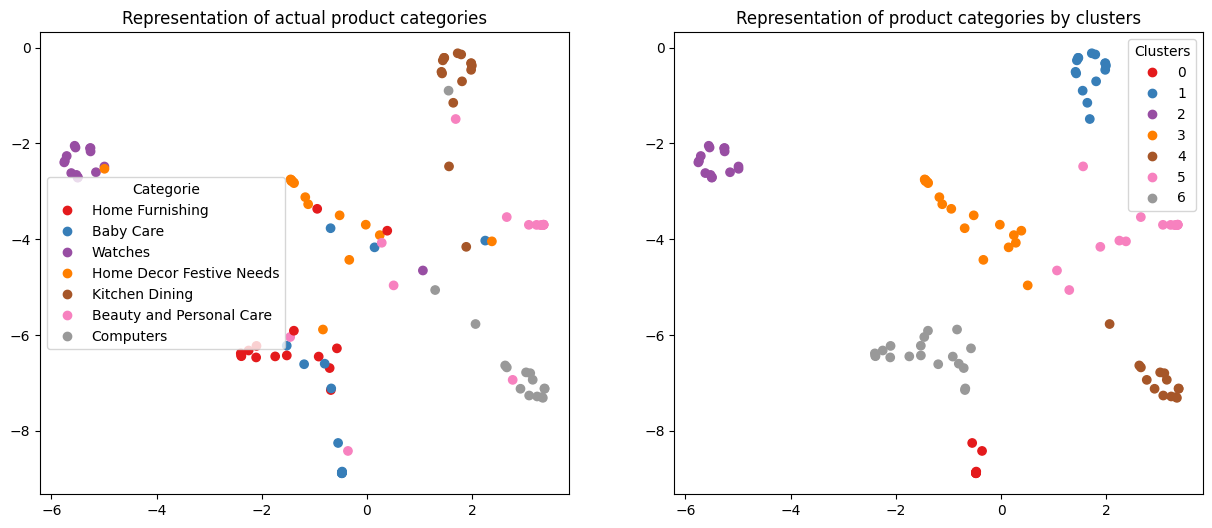

ARI :  0.8041


In [268]:
TSNE_visu_fct(X_tsne_inception_adv, true_labels, labels_inception_adv,
              ARI_inception_adv)

In [269]:
# Convert predictions to class indices
inception_advanced_predicted_classes = np.argmax(inception_predictions_adv,
                                              axis=1)
print(classification_report(true_labels, inception_advanced_predicted_classes))

              precision    recall  f1-score   support

           0       0.67      0.80      0.73        15
           1       0.75      0.60      0.67        15
           2       0.82      0.93      0.87        15
           3       0.85      0.73      0.79        15
           4       0.82      0.93      0.87        15
           5       0.69      0.60      0.64        15
           6       0.93      0.93      0.93        15

    accuracy                           0.79       105
   macro avg       0.79      0.79      0.79       105
weighted avg       0.79      0.79      0.79       105



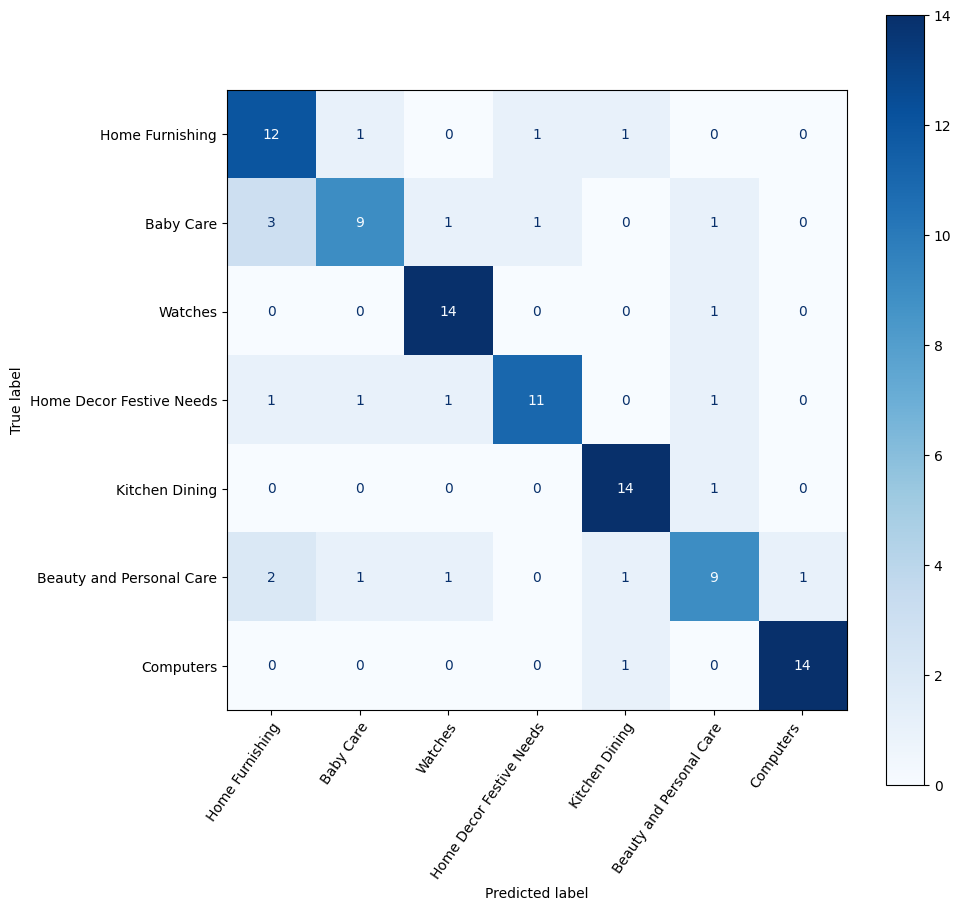

In [270]:
confusion_matrix_plot(true_labels, inception_advanced_predicted_classes, l_cat)

- **Basic data augmentation**: Basic data augmentation slightly reduced accuracy while improving test loss. This suggests that for datasets where the no-augmentation model already performs well, basic data augmentation may not be necessary and could even slightly degrade accuracy. However, it can be useful to improve the robustness of the model to minor variations.
- **Advanced data augmentation**: With advanced data augmentation, there is a noticeable improvement in test loss and an increase in accuracy compared to basic data augmentation, but not compared to the no-augmentation model. This indicates that advanced augmentation may be worth exploring when seeking to improve the robustness of the model to more significant variations. It could be particularly beneficial for datasets that are not as diverse or extensive.

In summary, the use of data augmentation, whether basic or advanced, should be carefully evaluated based on the baseline performance of the model and the specific characteristics of the dataset.
For already diverse and well-representative datasets, advanced data augmentation might not provide significant benefits in terms of accuracy,
although it can help reduce the loss and increase the robustness of the model.